# GAN-MNIST Generator

This notebook demonstrates a **Generative Adversarial Network (GAN)** that learns to generate handwritten digit images similar to the **MNIST dataset**.

- The **Generator** creates fake images from random noise.  
- The **Discriminator** classifies images as real or fake.  
- The network is trained so that the Generator improves over time and produces realistic images.

All code is implemented using **TensorFlow 2.x** and **Keras**.


In [ ]:
try :
  %tensorflow_version 2.x
except Exception :
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


**Import TensorFlow**

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.19.0'

**Install ImageIO**

In [ ]:
!pip install imageio

ImageIO is used for reading, writing, and saving image files, which is useful for saving the generated MNIST images during training.

**Import Additional Libraries**

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

**Load MNIST Dataset**

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

Loads the MNIST dataset of handwritten digits directly from TensorFlow.

`train_images` and `train_labels `contain the training images and their corresponding labels `(0–9).`

The `_ `variables represent the test dataset, which is ignored in this snippet.

***Preprocess MNIST Images***

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1

Reshape: Converts the images to shape `(num_images, 28, 28, 1)` so that each image has a single color channel (grayscale), as required by the GAN.

astype('float32'): Ensures all image data is in 32-bit floating point format for TensorFlow.

Normalization: Scales pixel values from` [0, 255]` to `[-1, 1] `to help the GAN train more efficiently.

Set Buffer and Batch Size

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256



*  **BUFFER_SIZE** : Number of images to shuffle in the dataset. A larger buffer ensures better randomness during training.

*   **BATCH_SIZE :** Number of images processed together in each training step. A batch size of 256 balances memory usage and training speed



**Prepare the Training Dataset**

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



*   Converts the train_images array into a TensorFlow Dataset object for efficient training.


*   shuffle(BUFFER_SIZE): Randomly shuffles the images to improve the GAN’s learning.

*   batch(BATCH_SIZE): Groups the images into batches of size 256 for processing in each training step.





**Build the Generator Model**

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same',
                                     use_bias=False, activation='tanh'))

    return model




*   Purpose: Defines the Generator in the GAN, which
creates fake MNIST images from random noise vectors

*   Dense layer: Expands the input noise vector (100 dimensions) into a large tensor of shape (7*7*256).



*   BatchNormalization: Stabilizes training and speeds up convergence.

*   LeakyReLU: Adds non-linearity while avoiding dying neurons.



*   Reshape: Converts the dense output into a 3D tensor (7, 7, 256) suitable for Conv2DTranspose layers.

*   Conv2DTranspose layers: Upsample the image step by step to reach (28, 28, 1) final image size.



*   Activation tanh: Scales pixel values to [-1, 1] to match the normalized training data.


**Generate a Sample Image**

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TensorShape([1, 28, 28, 1])

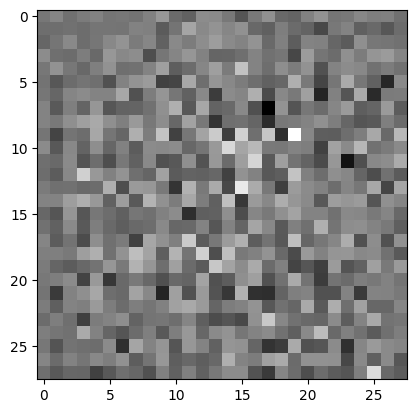

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = Generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
generated_image.shape

**Discriminator Model**

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

We built the Discriminator to classify images as real or fake.

First, we added a Dense layer with 46 units to extract key features from the images.

Real images are passed through the network so the Discriminator can learn what a genuine image looks like.

To prevent overfitting, we applied Dropout, which randomly ignores 30% of neurons during training.

Finally, the network produces a single output value that represents the probability that an image is real.

**Test the Discriminator**

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00067786]], shape=(1, 1), dtype=float32)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


We created the Discriminator model.

Passed a generated image from the Generator to the Discriminator.

The network outputs a value (decision) indicating whether it thinks the image is real or fake.

Printed the result to see the prediction.


**Define Loss Function**

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

We define Binary Cross-Entropy as the loss function.

This measures how well the Discriminator classifies real vs fake images, and how well the Generator fools the Discriminator.

**Discriminator Loss Function**

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

We define how the Discriminator loss is calculated.

real_loss: Measures how well the Discriminator predicts real images as 1.

fake_loss: Measures how well the Discriminator predicts fake images as 0.

total_loss: Sum of both, giving the overall performance of

**Generator Loss Function**

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

We define how the Generator loss is calculated.

The Generator tries to fool the Discriminator into thinking its fake images are real.

The loss measures how close the Discriminator’s output is to 1 for fake images.

Define Optimizers

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

We create Adam optimizers for both Generator and Discriminator.

The learning rate is set to` 1e-4 `for stable and efficient training.

These optimizers update the model weights based on the computed losses.

**Training Parameters and Seed**

In [ ]:
EP0CHS = 1
noise_dim = 100
num_examples_to_generae = 16
seed = tf.random.normal([num_examples_to_generae , noise_dim])


We define training parameters for the GAN.

`EPOCHS:` Number of training iterations over the dataset.

`noise_dim:` Size of the random noise vector for the Generator.

`num_examples_to_generate:` Number of sample images to generate for monitoring progress.

`seed:` Fixed random noise vector to generate consistent images during training.

**Single Training Step**

In [ ]:
# Notice the use of @tf.function
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  # تتبع التدرجات
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


Generate fake images from noise, compute losses for Generator and Discriminator, calculate gradients, and update weights.

`@tf.function` speeds up execution by compiling the function.

**Training Loop**

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)


Loops over epochs and batches in the dataset.

Calls train_step for each batch.

Generates and saves images after each epoch to monitor progress.

Prints time taken per epoch.

Generates final images after the last epoch.

**Generate and Save Images**

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    # Notice 'training' is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, 0] * 127.5 + 127.5), cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


Generates images from a fixed noise vector using the Generator in inference mode `(training=False)`.

Plots the images in a 4x4 grid.

Scales pixel values back from `[-1, 1]` to `[0, 255]`.

Saves each epoch’s images as PNG files and displays them

**Start Training**

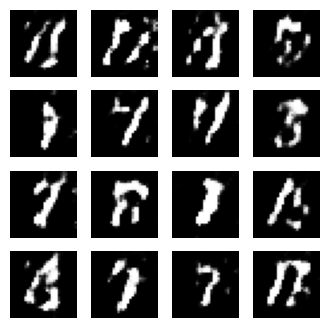

Time for epoch 12 is 725.737874507904 sec


In [ ]:
train(train_dataset, EPOCHS)

Starts training the GAN on the training dataset for the defined number of epochs.

During training, images are generated and saved after each epoch to monitor progress.